Binary 2/6 B)

mRNA localization using binary classification (cytoplasm/mitochondria) (part 1/2): basic model with: 
<br> 
<br>
a) Method 1: no feature selection and <br>
b) Method 4: with feature importance-based feature selection (get_feature_importance type (default) =  EFstrType.FeatureImportance), threshold 0 <br>
c) Method 5: with feature importance-based feature selection (feature importance type: SHAP values), threshold > 0

In [1]:
import pandas as pd
from catboost import CatBoostClassifier
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import shap

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, roc_auc_score, precision_recall_curve, roc_curve, auc, f1_score, classification_report


In [3]:
#data initialization

#Cytoplasm (label = 0)
CP_train = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_train_CSV.csv")
CP_test = pd.read_csv("../../Data/InputData/CP_iLearnfeatvalues_test_CSV.csv")

#Mitochondria (label = 2)
MT_train = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_train_CSV.csv")
MT_test = pd.read_csv("../../Data/InputData/MT_iLearnfeatvalues_test_CSV.csv")

print("CP TRAIN, TEST SHAPE:", CP_train.shape, ",", CP_test.shape)
print("MT TRAIN, TEST SHAPE:", MT_train.shape, ",", MT_test.shape)

CP TRAIN, TEST SHAPE: (824, 1026) , (206, 1026)
MT TRAIN, TEST SHAPE: (280, 1026) , (70, 1026)


In [4]:
###### NEXT STEP #######
#Merge training files for binary classification (CP+ER, CP+MT, CP+NU, ER+MT, ER+NU, MT+NU)
#Merge testing files same way

#How to merge: 
# - https://saturncloud.io/blog/how-to-merge-two-csv-files-into-one-with-pandas-by-id/
# or pd.concat


In [5]:


#Group 2: CP + MT

frames_CM_tra = [CP_train, MT_train]
frames_CM_tes = [CP_test, MT_test]

CP_MT_train = pd.concat(frames_CM_tra)
CP_MT_test = pd.concat(frames_CM_tes)


In [6]:

print("CP + MT TRAIN, TEST SHAPE:", CP_MT_train.shape, ",", CP_MT_test.shape)


CP + MT TRAIN, TEST SHAPE: (1104, 1026) , (276, 1026)


In [7]:
CP_MT_test.head(209)

,#,label,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,mRNALoc_16986#79230|0|testing,0,0.008836,0.002834,0.002334,0.003168,0.001667,0.003168,0.000000,0.002001,...,0.000834,0.001834,0.001167,0.000500,0.001667,0.001834,0.001667,0.002501,0.002001,0.011504
1,mRNALoc_8139#3082|0|testing,0,0.009503,0.002501,0.003168,0.006002,0.003001,0.000834,0.000167,0.002668,...,0.000167,0.003168,0.001667,0.001334,0.001667,0.003501,0.005835,0.001667,0.003501,0.005669
2,mRNALoc_19034#8816|0|testing,0,0.006005,0.001168,0.002168,0.001168,0.001668,0.001334,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001501,0.000667,0.001668,0.002502,0.001001,0.001334,0.002002
3,mRNALoc_19863#9737|0|testing,0,0.005673,0.001335,0.002503,0.002837,0.001502,0.001335,0.000167,0.001001,...,0.000000,0.001168,0.002002,0.001001,0.002670,0.001001,0.001168,0.000834,0.001669,0.001502
4,mRNALoc_19031#8816|0|testing,0,0.006008,0.001168,0.002170,0.001168,0.001669,0.001335,0.000167,0.000334,...,0.000167,0.001168,0.000834,0.001502,0.000668,0.001669,0.002503,0.001001,0.001335,0.002003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,mRNALoc_8179#30957|0|testing,0,0.000732,0.000183,0.000366,0.000732,0.000549,0.000366,0.000183,0.000732,...,0.000000,0.000183,0.000366,0.000732,0.000732,0.000549,0.000183,0.000183,0.000549,0.000000
205,mRNALoc_19660#94229|0|testing,0,0.006595,0.001465,0.002748,0.002565,0.002015,0.000550,0.000183,0.001099,...,0.000183,0.002381,0.003114,0.001649,0.001465,0.001832,0.002931,0.002565,0.003297,0.004396
0,mRNALoc_18808#856050|2|testing,2,0.001747,0.001747,0.005240,0.005240,0.001747,0.000873,0.002620,0.001747,...,0.000873,0.001747,0.001747,0.001747,0.001747,0.001747,0.001747,0.000873,0.001747,0.003493
1,mRNALoc_18516#852314|2|testing,2,0.010536,0.004390,0.004390,0.006146,0.003512,0.001756,0.000878,0.001756,...,0.000000,0.002634,0.003512,0.000878,0.003512,0.000878,0.001756,0.002634,0.004390,0.000000


In [8]:
#FOR CP+MT
noname_CM_train = CP_MT_train.drop("#", axis="columns")
noname_CM_test = CP_MT_test.drop("#", axis="columns")


CP_MT_X_train = noname_CM_train.drop("label", axis="columns")
CP_MT_y_train = noname_CM_train["label"]

CP_MT_X_test = noname_CM_test.drop("label", axis="columns")
CP_MT_y_test = noname_CM_test["label"]

print("CP + MT X train:", CP_MT_X_train.shape)
print("CP + MT y train:", CP_MT_y_train.shape)
print("CP + MT X test:", CP_MT_X_test.shape)
print("CP + MT y test:", CP_MT_y_test.shape)

CP + MT X train: (1104, 1024)
CP + MT y train: (1104,)
CP + MT X test: (276, 1024)
CP + MT y test: (276,)


In [9]:
# Create data pools for feature importance/selection for CP + MT

CM_feature_names = list(CP_MT_X_train.columns)
print("Number of features:", len(CM_feature_names))

CM_train_pool = Pool(CP_MT_X_train, CP_MT_y_train, feature_names=CM_feature_names)

CM_test_pool = Pool(CP_MT_X_test, CP_MT_y_test)

print("*Cytoplasm, Mitochondria Pools created")

Number of features: 1024
*Cytoplasm, Mitochondria Pools created


Initial classification (without feature importance/selection/hyperparameter tuning)

In [10]:
CM_binary_model = CatBoostClassifier(loss_function="MultiClass")

In [11]:
#Fit model to CM data

CM_binary_model.fit(CM_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6385453	total: 197ms	remaining: 3m 16s
1:	learn: 0.5928234	total: 360ms	remaining: 2m 59s
2:	learn: 0.5505704	total: 514ms	remaining: 2m 50s
3:	learn: 0.5132743	total: 666ms	remaining: 2m 45s
4:	learn: 0.4791225	total: 806ms	remaining: 2m 40s
5:	learn: 0.4486560	total: 971ms	remaining: 2m 40s
6:	learn: 0.4209915	total: 1.11s	remaining: 2m 37s
7:	learn: 0.3940899	total: 1.24s	remaining: 2m 34s
8:	learn: 0.3697795	total: 1.38s	remaining: 2m 31s
9:	learn: 0.3472277	total: 1.51s	remaining: 2m 29s
10:	learn: 0.3264301	total: 1.66s	remaining: 2m 29s
11:	learn: 0.3084585	total: 1.81s	remaining: 2m 29s
12:	learn: 0.2910456	total: 1.96s	remaining: 2m 28s
13:	learn: 0.2771808	total: 2.11s	remaining: 2m 28s
14:	learn: 0.2629835	total: 2.26s	remaining: 2m 28s
15:	learn: 0.2490119	total: 2.4s	remaining: 2m 27s
16:	learn: 0.2361546	total: 2.53s	remaining: 2m 26s
17:	learn: 0.2245013	total: 2.67s	remaining: 2m 25s
18:	learn: 0.2136407	total: 2.8s	remaining: 2

In [12]:
#Check parameters used in this model fit

CM_bin_params = CM_binary_model.get_all_params()
print("Basic model parameters:", CM_bin_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [13]:
#Prediction using X_test
CM_y_pred = CM_binary_model.predict(CP_MT_X_test)

#Predication probability

CM_y_prob = CM_binary_model.predict_proba(CP_MT_X_test)

In [14]:
# Calculate F1 score and get classification report

print("Model 1: Basic model - Cytoplasm & mitochondira")

CM_cr = classification_report(CP_MT_y_test, CM_y_pred, digits=3)
print(CM_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_y_pred))

CM_f1 = f1_score(CP_MT_y_test, CM_y_pred, average='macro')
print(f"F1 Score: {CM_f1}")

# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_y_prob))

Model 1: Basic model - Cytoplasm & mitochondira
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029
F1 Score: 0.9951922239448151


In [15]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_y_pred.shape)

CM_y_pred_fl = CM_y_pred
print("flattened prediction values shape:", CM_y_pred_fl.ravel().shape, "\n")

CM_cMatrix = confusion_matrix(CP_MT_y_test, CM_y_pred_fl)
print(CM_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


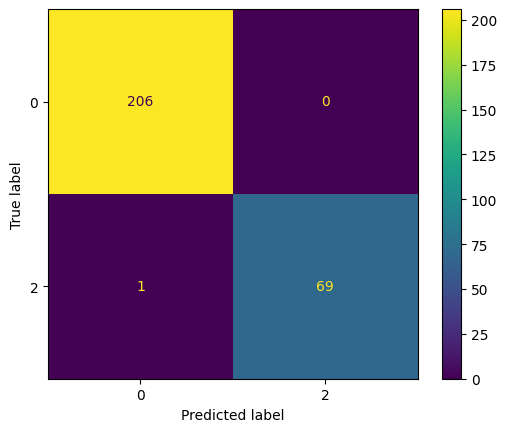

In [16]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_cMatrix, display_labels=CM_binary_model.classes_)
disp.plot()
plt.show()

    Method 4: Feature importance-based feature selection ("PredictionValuesChange"), threshold > 0

In [17]:
#Feature importances for CM pair

CM_feat_importances = CM_binary_model.get_feature_importance(prettified=True)
CM_feat_importances.head(100)

,Feature Id,Importances
0,TATCG,9.201081
1,CCCCC,5.027435
2,ACGAA,3.133898
3,TTACG,2.614947
4,CAGCC,2.538007
...,...,...
95,TCAAG,0.184023
96,CATTG,0.182816
97,CAGGG,0.182110
98,CTGGG,0.179269


In [18]:
# Show only feature importances above 0

threshold_chosen_features = CM_feat_importances[CM_feat_importances['Importances'] > 0]
num_chosen_features = len(threshold_chosen_features)

print(threshold_chosen_features)

print("\nAmount of features with importnace above 0 (selected features):", num_chosen_features)

    Feature Id   Importances
0        TATCG  9.201081e+00
1        CCCCC  5.027435e+00
2        ACGAA  3.133898e+00
3        TTACG  2.614947e+00
4        CAGCC  2.538007e+00
..         ...           ...
754      CACGT  1.029376e-05
755      AGACT  6.087953e-06
756      GAGAT  4.365936e-06
757      GTACG  3.649247e-06
758      TGCGT  3.328051e-07

[759 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 759


In [19]:
print("Sum of total feature importances: ", sum(CM_feat_importances.Importances))
print("Sum of feature importances > 0: ", sum(threshold_chosen_features.Importances))

Sum of total feature importances:  99.99999999999991
Sum of feature importances > 0:  99.99999999999991


In [21]:
# Select features with importance values above 0.1

CM_selected_feat = CM_feat_importances[:num_chosen_features]['Feature Id'].tolist()

# print(CM_selected_feat)

In [22]:
CP_MT_X_train.shape

(1104, 1024)

In [23]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [24]:
#Create training set with selected features 

CM_X_train_selected = CP_MT_X_train[CM_selected_feat]
CM_X_train_selected.head()

,TATCG,CCCCC,ACGAA,TTACG,CAGCC,TCCAA,CGGTA,ACGTT,TCGTT,CCCAG,...,CGTCT,CGAGG,ACGCA,TCTAA,CGACC,CACGT,AGACT,GAGAT,GTACG,TGCGT
0,0.000000,0.001267,0.000475,0.000158,0.000792,0.001584,0.000158,0.000000,0.000317,0.002376,...,0.000000,0.001901,0.000317,0.001267,0.000317,0.000317,0.001267,0.001426,0.000158,0.000317
1,0.000000,0.003205,0.000000,0.000000,0.004662,0.001166,0.000000,0.000583,0.000291,0.003497,...,0.000874,0.001166,0.000000,0.000000,0.001457,0.000291,0.000291,0.001166,0.000291,0.000000
2,0.000458,0.000458,0.000000,0.000000,0.001833,0.002750,0.000000,0.000000,0.000458,0.002750,...,0.000000,0.000458,0.000000,0.001375,0.000458,0.000000,0.000458,0.000917,0.000000,0.000000
3,0.000000,0.004948,0.000000,0.000000,0.003464,0.000990,0.000000,0.000000,0.000000,0.004453,...,0.000000,0.000990,0.000495,0.000495,0.001484,0.000000,0.000990,0.000495,0.000000,0.000000
4,0.000000,0.000622,0.000415,0.000207,0.001037,0.001037,0.000000,0.000207,0.000104,0.002073,...,0.000311,0.000311,0.000207,0.001037,0.000104,0.000000,0.000726,0.001348,0.000207,0.000207


In [25]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_selected.columns) == CM_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [26]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 759)
Shape of y_train (number of labels): (1104,)


In [27]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_selected_feat))

CM_selected_train_pool = Pool(CM_X_train_selected, CP_MT_y_train, feature_names=CM_selected_feat)

Original number of features: 1024 
 Number of selected features: 759


In [28]:
#Create new model for data with selected features
CM_FIFS_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CM_FIFS_model.fit(CM_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6439222	total: 115ms	remaining: 1m 55s
1:	learn: 0.5958228	total: 202ms	remaining: 1m 40s
2:	learn: 0.5502251	total: 299ms	remaining: 1m 39s
3:	learn: 0.5137254	total: 391ms	remaining: 1m 37s
4:	learn: 0.4767157	total: 491ms	remaining: 1m 37s
5:	learn: 0.4463814	total: 590ms	remaining: 1m 37s
6:	learn: 0.4184288	total: 687ms	remaining: 1m 37s
7:	learn: 0.3927374	total: 788ms	remaining: 1m 37s
8:	learn: 0.3690057	total: 882ms	remaining: 1m 37s
9:	learn: 0.3458600	total: 974ms	remaining: 1m 36s
10:	learn: 0.3264732	total: 1.08s	remaining: 1m 37s
11:	learn: 0.3079142	total: 1.18s	remaining: 1m 36s
12:	learn: 0.2914782	total: 1.27s	remaining: 1m 36s
13:	learn: 0.2751886	total: 1.37s	remaining: 1m 36s
14:	learn: 0.2609556	total: 1.49s	remaining: 1m 37s
15:	learn: 0.2470748	total: 1.63s	remaining: 1m 40s
16:	learn: 0.2343987	total: 1.75s	remaining: 1m 41s
17:	learn: 0.2228205	total: 1.87s	remaining: 1m 42s
18:	learn: 0.2115627	total: 1.99s	remaining:

In [29]:
#Check parameters used in this model fit

CM_FIFS_params = CM_FIFS_model.get_all_params()
print("Basic model parameters:", CM_FIFS_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [30]:
#Prediction using X_test only for selected features data
CM_FIFS_y_pred = CM_FIFS_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_y_prob = CM_FIFS_model.predict_proba(CP_MT_X_test)

In [34]:
# Calculate F1 score and get classification report

print("Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Cytoplasm & mitochondria")

print("\nNumber of chosen features:", num_chosen_features, "\n")

CM_FIFS_cr = classification_report(CP_MT_y_test, CM_FIFS_y_pred, digits=3)
print(CM_FIFS_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_y_pred))

CM_FIFS_f1 = f1_score(CP_MT_y_test, CM_FIFS_y_pred, average='macro')
print(f"F1 Score: {CM_FIFS_f1}")
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_y_prob))

Model 4: Feature selection (PredictionValuesChange) w/ threshold > 0 - Cytoplasm & mitochondria

Number of chosen features: 759 

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       206
           2      1.000     1.000     1.000        70

    accuracy                          1.000       276
   macro avg      1.000     1.000     1.000       276
weighted avg      1.000     1.000     1.000       276

Accuracy score:  1.0
F1 Score: 1.0


In [35]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_y_pred.shape)

CM_FIFS_y_pred_fl = CM_FIFS_y_pred
print("flattened prediction values shape:", CM_FIFS_y_pred_fl.ravel().shape, "\n")

CM_FIFS_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_y_pred_fl)
print(CM_FIFS_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  0  70]]


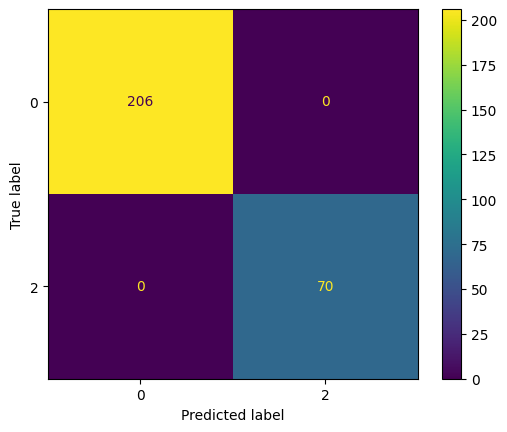

In [36]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_cMatrix, display_labels=CM_FIFS_model.classes_)
disp.plot()
plt.show()

    Method 5: Modelling using feature selection based on feature importance values (with get_feature_importances type = "ShapValues") w/ threshold > 0

In [37]:
#SHAP explainer to explain CatBoost output
explainer = shap.TreeExplainer(CM_binary_model)

In [38]:
#SHAP values for X_train
CM_shap_values = explainer.shap_values(CP_MT_X_train)

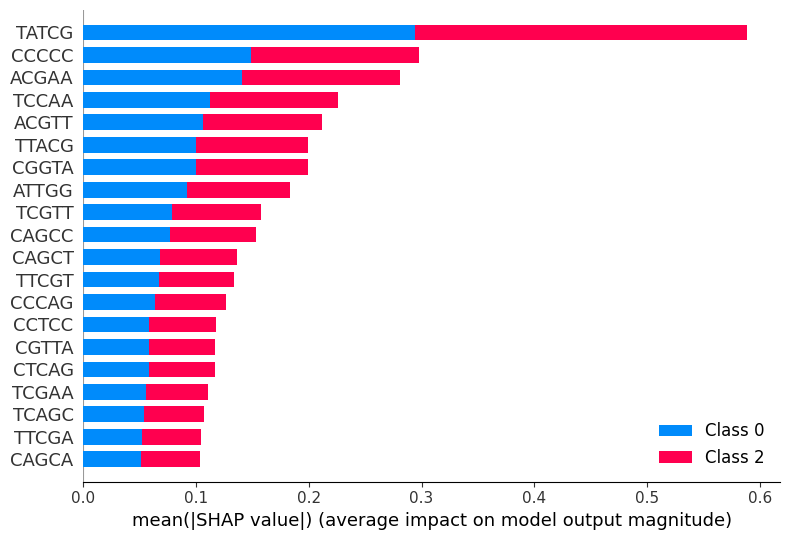

In [39]:
shap.summary_plot(CM_shap_values, CP_MT_X_train, plot_size=0.2, class_names=["Class 0", "Class 2"])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


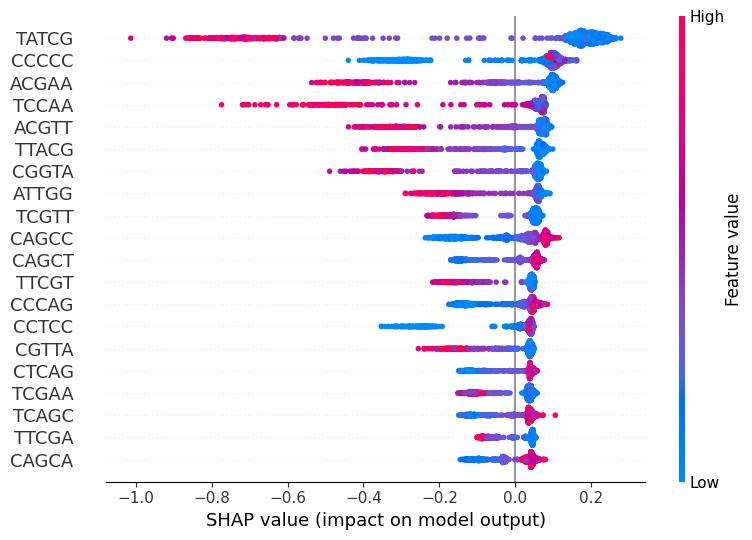

In [40]:
shap.summary_plot(CM_shap_values[0], CP_MT_X_train, plot_size=0.2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


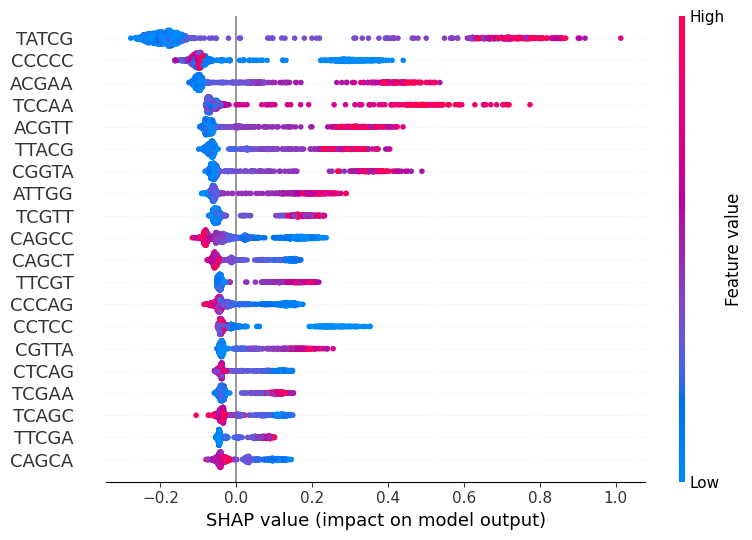

In [41]:
shap.summary_plot(CM_shap_values[1], CP_MT_X_train, plot_size=0.2)

In [42]:
shap_df = pd.DataFrame(CM_shap_values[0], columns=CP_MT_X_train.columns)


In [43]:
CM_shap_FI = (shap_df[shap_df>0]
                                .mean()
                                .sort_values(ascending=False)
                                .reset_index()
                                .rename(columns={'index':'Feature Id', 0:'Importances'})
                                # .head()
                        )

In [44]:
CM_shap_FI.head(100)

#### Check these feautre values with the features on shap plot for CP above #####
# Might need to use other method to get only features in with positive outcome + in red (those in red on right side):


,Feature Id,Importances
0,TATCG,0.189363
1,CCCCC,0.098708
2,ACGAA,0.096144
3,ACGTT,0.070300
4,TGTAA,0.068956
...,...,...
95,AGCAG,0.010619
96,GGGCC,0.010426
97,ATCAA,0.010309
98,CATTG,0.010241


In [42]:
# shap.summary_plot(CM_shap_values[0], CP_MT_X_train, show=False, max_display=30, plot_size=0.2)

In [43]:
#Classifier results with CM_feature_importance

In [45]:
# Show only feature importances above 0

CM_SHAP_thres_chosen = CM_shap_FI[CM_shap_FI['Importances'] > 0]
CM_shap_num_chosen = len(CM_SHAP_thres_chosen)

print(CM_SHAP_thres_chosen)

print("\nAmount of features with importnace above 0 (selected features):", CM_shap_num_chosen)

    Feature Id  Importances
0        TATCG     0.189363
1        CCCCC     0.098708
2        ACGAA     0.096144
3        ACGTT     0.070300
4        TGTAA     0.068956
..         ...          ...
754      AGCTT     0.000009
755      ACGCA     0.000005
756      AGACT     0.000003
757      GAGAT     0.000002
758      GTACG     0.000001

[759 rows x 2 columns]

Amount of features with importnace above 0 (selected features): 759


In [46]:
print("Sum of total feature importances: ", sum(CM_shap_FI.Importances))
print("Sum of feature importances > 0: ", sum(CM_SHAP_thres_chosen.Importances))

Sum of total feature importances:  nan
Sum of feature importances > 0:  4.324174420023983


In [48]:
# Select features with importance values above 0.1

CM_shap_selected_feat = CM_shap_FI[:CM_shap_num_chosen]['Feature Id'].tolist()

# print(CM_shap_selected_feat)

In [49]:
CP_MT_X_train.shape

(1104, 1024)

In [50]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [51]:
#Create training set with selected features 

CM_X_train_shap_selected = CP_MT_X_train[CM_shap_selected_feat]
CM_X_train_shap_selected.head()

,TATCG,CCCCC,ACGAA,ACGTT,TGTAA,TTACG,TCCAA,ATTGG,CGGTA,CAGCC,...,ATGGG,TAGCT,ACTTT,AGCTA,CGTCT,AGCTT,ACGCA,AGACT,GAGAT,GTACG
0,0.000000,0.001267,0.000475,0.000000,0.001426,0.000158,0.001584,0.000950,0.000158,0.000792,...,0.000792,0.000317,0.000792,0.000792,0.000000,0.000792,0.000317,0.001267,0.001426,0.000158
1,0.000000,0.003205,0.000000,0.000583,0.000291,0.000000,0.001166,0.000583,0.000000,0.004662,...,0.000874,0.000000,0.000291,0.000874,0.000874,0.000291,0.000000,0.000291,0.001166,0.000291
2,0.000458,0.000458,0.000000,0.000000,0.000000,0.000000,0.002750,0.000458,0.000000,0.001833,...,0.000000,0.001375,0.000917,0.000917,0.000000,0.002750,0.000000,0.000458,0.000917,0.000000
3,0.000000,0.004948,0.000000,0.000000,0.000000,0.000000,0.000990,0.000000,0.000000,0.003464,...,0.001979,0.000990,0.000000,0.000990,0.000000,0.000990,0.000495,0.000990,0.000495,0.000000
4,0.000000,0.000622,0.000415,0.000207,0.001451,0.000207,0.001037,0.001244,0.000000,0.001037,...,0.001348,0.001244,0.001659,0.001244,0.000311,0.001659,0.000207,0.000726,0.001348,0.000207


In [52]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_shap_selected.columns) == CM_shap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [53]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_shap_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 759)
Shape of y_train (number of labels): (1104,)


In [54]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_shap_selected_feat))

CM_shap_selected_train_pool = Pool(CM_X_train_shap_selected, CP_MT_y_train, feature_names=CM_shap_selected_feat)

Original number of features: 1024 
 Number of selected features: 759


In [55]:
#Create new model for data with selected features
CM_FIFS_shap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CM_FIFS_shap_model.fit(CM_shap_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6419691	total: 118ms	remaining: 1m 57s
1:	learn: 0.5926465	total: 214ms	remaining: 1m 46s
2:	learn: 0.5476757	total: 322ms	remaining: 1m 47s
3:	learn: 0.5103457	total: 423ms	remaining: 1m 45s
4:	learn: 0.4725831	total: 526ms	remaining: 1m 44s
5:	learn: 0.4414945	total: 649ms	remaining: 1m 47s
6:	learn: 0.4150345	total: 750ms	remaining: 1m 46s
7:	learn: 0.3917317	total: 844ms	remaining: 1m 44s
8:	learn: 0.3684474	total: 950ms	remaining: 1m 44s
9:	learn: 0.3472305	total: 1.04s	remaining: 1m 43s
10:	learn: 0.3274153	total: 1.14s	remaining: 1m 42s
11:	learn: 0.3093750	total: 1.24s	remaining: 1m 42s
12:	learn: 0.2932659	total: 1.33s	remaining: 1m 41s
13:	learn: 0.2763011	total: 1.42s	remaining: 1m 40s
14:	learn: 0.2614204	total: 1.52s	remaining: 1m 39s
15:	learn: 0.2468968	total: 1.61s	remaining: 1m 38s
16:	learn: 0.2335179	total: 1.7s	remaining: 1m 38s
17:	learn: 0.2221266	total: 1.8s	remaining: 1m 38s
18:	learn: 0.2113358	total: 1.91s	remaining: 1

In [56]:
#Check parameters used in this model fit

CM_FIFS_shap_params = CM_FIFS_shap_model.get_all_params()
print("Basic model parameters:", CM_FIFS_shap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [57]:
#Prediction using X_test only for selected features data
CM_FIFS_shap_y_pred = CM_FIFS_shap_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_shap_y_prob = CM_FIFS_shap_model.predict_proba(CP_MT_X_test)

In [58]:
# Calculate F1 score and get classification report

print("Model 5: Feature selection (SHAP) w/ threshold > 0 - Cytoplasm & mitochondria")

print("Number of chosen features:", len(CM_shap_selected_feat), "\n")

CM_FIFS_shap_cr = classification_report(CP_MT_y_test, CM_FIFS_shap_y_pred, digits=3)
print(CM_FIFS_shap_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_shap_y_pred))


CM_FIFS_shap_f1 = f1_score(CP_MT_y_test, CM_FIFS_shap_y_pred, average='macro')
print(f"\nF1 Score: {CM_FIFS_shap_f1}")
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_shap_y_prob))

Model 5: Feature selection (SHAP) w/ threshold > 0 - Cytoplasm & mitochondria
Number of chosen features: 759 

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       206
           2      1.000     1.000     1.000        70

    accuracy                          1.000       276
   macro avg      1.000     1.000     1.000       276
weighted avg      1.000     1.000     1.000       276

Accuracy score:  1.0

F1 Score: 1.0


In [59]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_shap_y_pred.shape)

CM_FIFS_shap_y_pred_fl = CM_FIFS_shap_y_pred
print("flattened prediction values shape:", CM_FIFS_shap_y_pred_fl.ravel().shape, "\n")

CM_FIFS_shap_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_shap_y_pred_fl)
print(CM_FIFS_shap_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  0  70]]


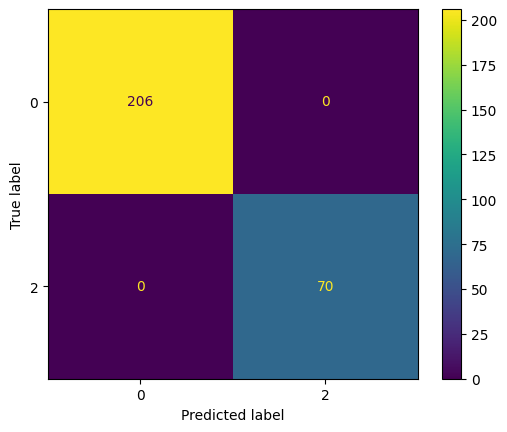

In [60]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_shap_cMatrix, display_labels=CM_FIFS_shap_model.classes_)
disp.plot()
plt.show()

In [62]:
#Classifier results with newtry_feature_importance

In [ ]:
#Try####

vals= np.abs(CM_shap_values).mean(0)

newtry_feature_importance = pd.DataFrame(list(zip(CP_MT_X_train.columns, sum(vals))), columns=['col_name','feature_importanCM_vals'])
newtry_feature_importance.sort_values(by=['feature_importanCM_vals'], ascending=False,inplace=True)
newtry_feature_importance

,col_name,feature_importanCM_vals
822,TATCG,324.907479
341,CCCCC,164.339777
96,ACGAA,154.970735
848,TCCAA,124.460883
111,ACGTT,116.747471
...,...,...
53,AATCC,0.000000
480,CTGAA,0.000000
476,CTCTA,0.000000
475,CTCGT,0.000000


In [80]:
newtry_feature_importance.head(100)

,col_name,feature_importanCM_vals
822,TATCG,324.907479
341,CCCCC,164.339777
96,ACGAA,154.970735
848,TCCAA,124.460883
111,ACGTT,116.747471
...,...,...
246,ATTCG,11.585036
269,CAATC,11.518960
28,AACTA,11.382042
354,CCGAG,11.229052


In [81]:
# Show only feature importances above 0.1

CM_newSHAP_thres_chosen = newtry_feature_importance[newtry_feature_importance["feature_importance_vals"] > 0.02]
CM_newshap_num_chosen = len(CM_newSHAP_thres_chosen)

print(CM_newSHAP_thres_chosen)

print("\nAmount of features with importnace above 0.1 (selected features):", CM_newshap_num_chosen)

    col_name  feature_importanCM_vals
822    TATCG               324.907479
341    CCCCC               164.339777
96     ACGAA               154.970735
848    TCCAA               124.460883
111    ACGTT               116.747471
..       ...                      ...
246    ATTCG                11.585036
269    CAATC                11.518960
28     AACTA                11.382042
354    CCGAG                11.229052
536    GACGA                11.221753

[100 rows x 2 columns]

Amount of features with importnace above 0.1 (selected features): 100


In [82]:
print("Sum of total feature importances: ", sum(newtry_feature_importance.feature_importanCM_vals))
print("Sum of feature importances > 0.1: ", sum(CM_newSHAP_thres_chosen.feature_importanCM_vals))

Sum of total feature importances:  5628.551290067104
Sum of feature importances >=0.1:  3907.5025224662436


In [83]:
# Select features with importance values above 0.1

CM_newshap_selected_feat = newtry_feature_importance[:CM_newshap_num_chosen]['col_name'].tolist()

print(CM_newshap_selected_feat)

['TATCG', 'CCCCC', 'ACGAA', 'TCCAA', 'ACGTT', 'TTACG', 'CGGTA', 'ATTGG', 'TCGTT', 'CAGCC', 'CAGCT', 'TTCGT', 'CCCAG', 'CCTCC', 'CGTTA', 'CTCAG', 'TCGAA', 'TCAGC', 'TTCGA', 'CAGCA', 'TATGG', 'TGTAA', 'GCCTG', 'GGCCT', 'TGACG', 'GGTAC', 'CCTGG', 'CTGAG', 'GGTAT', 'CACAG', 'TGGTA', 'GTCGT', 'ACGAT', 'CCCCT', 'CGATT', 'CTATT', 'CAGTC', 'CCAGG', 'CGATA', 'CGTTG', 'GGCAT', 'TCGAT', 'ATTGA', 'CGTAA', 'CGAAA', 'CCCTG', 'CACCC', 'TTGCG', 'TAACG', 'GTGTG', 'ATACG', 'CCGAT', 'AAAAA', 'TTGGT', 'ATTAC', 'TTTCG', 'GACCT', 'GGGGC', 'ATCCG', 'TATTG', 'CTCCC', 'GGGCC', 'GGGAG', 'ACACA', 'ATCGT', 'AGCAG', 'ACCCC', 'CTGGG', 'CGATG', 'TACGA', 'CCCGG', 'CATTG', 'CAGGG', 'GACGT', 'ACGCT', 'TCCTG', 'ATCAA', 'GCGAA', 'ATCGA', 'TACGT', 'CGCGC', 'AGCCC', 'TGTGT', 'ATCGG', 'AGTCC', 'CGTAT', 'CAGGC', 'GCCAG', 'TACGG', 'AGGGG', 'ATCCA', 'CGTCA', 'GGAGC', 'TCAGA', 'GTTAG', 'ATTCG', 'CAATC', 'AACTA', 'CCGAG', 'GACGA']


In [84]:
CP_MT_X_train.shape

(1104, 1024)

In [85]:
# See original training set

CP_MT_X_train.head(826)


,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,AAAGC,...,TTTCG,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT
0,0.003643,0.000792,0.001426,0.002218,0.001584,0.000950,0.000792,0.000950,0.001901,0.001742,...,0.000000,0.002693,0.002059,0.001109,0.001109,0.002534,0.001584,0.001901,0.003168,0.003643
1,0.002914,0.000291,0.000583,0.000291,0.000583,0.000000,0.000000,0.000583,0.000874,0.001457,...,0.000583,0.000291,0.000583,0.000291,0.000000,0.001166,0.000291,0.001166,0.000583,0.000291
2,0.002291,0.001375,0.000458,0.001375,0.000000,0.000917,0.000458,0.001375,0.001375,0.000917,...,0.000917,0.001375,0.000917,0.000458,0.000458,0.000917,0.000917,0.002750,0.000458,0.000458
3,0.000000,0.000990,0.000495,0.000000,0.000990,0.000990,0.000000,0.000495,0.001484,0.000000,...,0.000000,0.000495,0.000990,0.000000,0.001484,0.000495,0.000495,0.000000,0.000000,0.000000
4,0.013061,0.002488,0.004043,0.004354,0.001451,0.001348,0.000415,0.002902,0.003110,0.001244,...,0.000311,0.001762,0.001970,0.000933,0.002591,0.001970,0.002695,0.002384,0.002488,0.003732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,0.004328,0.002331,0.002331,0.002664,0.002997,0.000499,0.000000,0.001665,0.002331,0.002664,...,0.000000,0.002664,0.001998,0.001665,0.001332,0.003329,0.002331,0.001998,0.002664,0.003995
822,0.004830,0.001499,0.002498,0.004997,0.002332,0.001332,0.000333,0.000833,0.001832,0.001166,...,0.000000,0.002498,0.002831,0.001332,0.001832,0.003664,0.006329,0.002998,0.003831,0.008494
823,0.002500,0.000167,0.000500,0.000167,0.000500,0.000667,0.000167,0.000667,0.000667,0.000333,...,0.000167,0.000667,0.001167,0.000167,0.000333,0.000333,0.000333,0.000167,0.000167,0.000500
0,0.003945,0.001255,0.002690,0.002152,0.001435,0.000359,0.001076,0.001435,0.001973,0.001435,...,0.001614,0.001255,0.003407,0.001435,0.001435,0.001973,0.001435,0.001435,0.002869,0.001435


In [86]:
#Create training set with selected features 

CM_X_train_newshap_selected = CP_MT_X_train[CM_newshap_selected_feat]
CM_X_train_newshap_selected.head()

,TATCG,CCCCC,ACGAA,TCCAA,ACGTT,TTACG,CGGTA,ATTGG,TCGTT,CAGCC,...,ATCCA,CGTCA,GGAGC,TCAGA,GTTAG,ATTCG,CAATC,AACTA,CCGAG,GACGA
0,0.000000,0.001267,0.000475,0.001584,0.000000,0.000158,0.000158,0.000950,0.000317,0.000792,...,0.001267,0.000158,0.001584,0.001267,0.000475,0.000158,0.000792,0.000950,0.001901,0.000000
1,0.000000,0.003205,0.000000,0.001166,0.000583,0.000000,0.000000,0.000583,0.000291,0.004662,...,0.000291,0.000000,0.003497,0.001748,0.000583,0.000291,0.000000,0.000291,0.001457,0.000000
2,0.000458,0.000458,0.000000,0.002750,0.000000,0.000000,0.000000,0.000458,0.000458,0.001833,...,0.000917,0.000458,0.001833,0.002291,0.000458,0.000458,0.000000,0.000917,0.000917,0.000458
3,0.000000,0.004948,0.000000,0.000990,0.000000,0.000000,0.000000,0.000000,0.000000,0.003464,...,0.000990,0.000000,0.002474,0.001484,0.000000,0.000000,0.000000,0.000000,0.000495,0.000990
4,0.000000,0.000622,0.000415,0.001037,0.000207,0.000207,0.000000,0.001244,0.000104,0.001037,...,0.001037,0.000000,0.001037,0.001140,0.001037,0.000207,0.000415,0.001659,0.000207,0.000415


In [87]:
# Check whether columns in new training set are the same featues are the ones selected
if(list(CM_X_train_newshap_selected.columns) == CM_newshap_selected_feat):
    print("Selected and column features are the same; properly selected");
else:
    print("Features not selected properly")

Selected and column features are the same; properly selected


In [88]:
# Check whether number of variables/sequences of training set is the same as number of labels (no change should have been made to the sequences (rows), only to the features (columns)) 
print("Shape of X_train_selected (number of variables/sequences):", CM_X_train_newshap_selected.shape)
print("Shape of y_train (number of labels):", CP_MT_y_train.shape)

Shape of X_train_selected (number of variables/sequences): (1104, 100)
Shape of y_train (number of labels): (1104,)


In [89]:
# Create pool object for selected feature data
print("Original number of features:", len(CM_feature_names), "\n Number of selected features:", len(CM_newshap_selected_feat))

CM_newshap_selected_train_pool = Pool(CM_X_train_newshap_selected, CP_MT_y_train, feature_names=CM_newshap_selected_feat)

Original number of features: 1024 
 Number of selected features: 100


In [90]:
#Create new model for data with selected features
CM_FIFS_newshap_model = CatBoostClassifier(loss_function="MultiClass")

# Fit new data into same model as before

CM_FIFS_newshap_model.fit(CM_newshap_selected_train_pool)

Learning rate set to 0.079527
0:	learn: 0.6359069	total: 78.9ms	remaining: 1m 18s
1:	learn: 0.5860164	total: 98ms	remaining: 48.9s
2:	learn: 0.5398971	total: 111ms	remaining: 37s
3:	learn: 0.4998063	total: 125ms	remaining: 31.1s
4:	learn: 0.4653281	total: 139ms	remaining: 27.7s
5:	learn: 0.4325161	total: 154ms	remaining: 25.5s
6:	learn: 0.4030002	total: 168ms	remaining: 23.9s
7:	learn: 0.3772330	total: 182ms	remaining: 22.6s
8:	learn: 0.3530650	total: 197ms	remaining: 21.6s
9:	learn: 0.3314076	total: 228ms	remaining: 22.6s
10:	learn: 0.3106960	total: 245ms	remaining: 22.1s
11:	learn: 0.2919670	total: 262ms	remaining: 21.6s
12:	learn: 0.2744920	total: 279ms	remaining: 21.1s
13:	learn: 0.2598854	total: 295ms	remaining: 20.7s
14:	learn: 0.2455660	total: 309ms	remaining: 20.3s
15:	learn: 0.2324850	total: 322ms	remaining: 19.8s
16:	learn: 0.2211207	total: 335ms	remaining: 19.4s
17:	learn: 0.2092669	total: 351ms	remaining: 19.1s
18:	learn: 0.1981200	total: 371ms	remaining: 19.2s
19:	learn: 0

In [91]:
#Check parameters used in this model fit

CM_FIFS_newshap_params = CM_FIFS_newshap_model.get_all_params()
print("Basic model parameters:", CM_FIFS_newshap_params)

Basic model parameters: {'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'use_best_model': False, 'class_names': [0, 2], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.07952699810266495,

In [92]:
#Prediction using X_test only for selected features data
CM_FIFS_newshap_y_pred = CM_FIFS_newshap_model.predict(CP_MT_X_test)

#Predication probability for selected features data

CM_FIFS_newshap_y_prob = CM_FIFS_newshap_model.predict_proba(CP_MT_X_test)

In [93]:
# Calculate F1 score and get classification report

CM_FIFS_newshap_f1 = f1_score(CP_MT_y_test, CM_FIFS_newshap_y_pred, average='macro')
print(f"F1 Score: {CM_FIFS_newshap_f1}")

CM_FIFS_newshap_cr = classification_report(CP_MT_y_test, CM_FIFS_newshap_y_pred, digits=3)
print(CM_FIFS_newshap_cr)

print('Accuracy score: ', accuracy_score(CP_MT_y_test, CM_FIFS_newshap_y_pred))
# print('Roc auc score : ', roc_auc_score(CP_MT_y_test, CM_FIFS_newshap_y_prob))

F1 Score: 0.9951922239448151
              precision    recall  f1-score   support

           0      0.995     1.000     0.998       206
           2      1.000     0.986     0.993        70

    accuracy                          0.996       276
   macro avg      0.998     0.993     0.995       276
weighted avg      0.996     0.996     0.996       276

Accuracy score:  0.9963768115942029


In [94]:
# Confusion matrix for selected data

print("real values shape:", CP_MT_y_test.shape)
print("prediction shape:", CM_FIFS_newshap_y_pred.shape)

CM_FIFS_newshap_y_pred_fl = CM_FIFS_newshap_y_pred
print("flattened prediction values shape:", CM_FIFS_newshap_y_pred_fl.ravel().shape, "\n")

CM_FIFS_newshap_cMatrix = confusion_matrix(CP_MT_y_test, CM_FIFS_newshap_y_pred_fl)
print(CM_FIFS_newshap_cMatrix)

real values shape: (276,)
prediction shape: (276, 1)
flattened prediction values shape: (276,) 

[[206   0]
 [  1  69]]


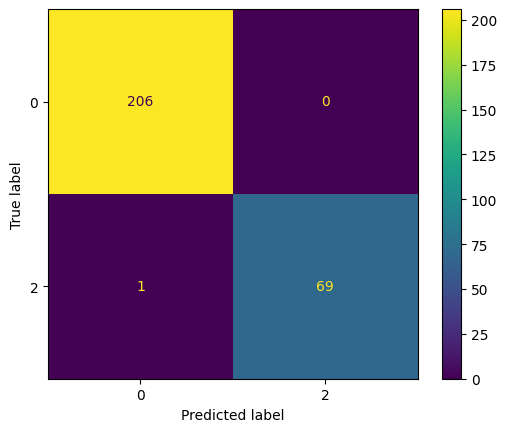

In [95]:
# Show image of confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=CM_FIFS_newshap_cMatrix, display_labels=CM_FIFS_newshap_model.classes_)
disp.plot()
plt.show()